In [1]:
%%capture
!pip install gdown contextily

In [2]:
import gdown

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import contextily as ctx
import xml.etree.ElementTree as ET

from matplotlib.patches import FancyArrowPatch

In [3]:
%%capture

ROUTE_GPX = 'route.gpx'
ROUTE_GPX_URL = 'https://drive.google.com/file/d/1BBELrv8nF8T6-JRQWadSkFzHlzgINhx1/view?usp=sharing'

gdown.download(ROUTE_GPX_URL, ROUTE_GPX, quiet=True, fuzzy=True)

In [4]:
def parse_gpx(filepath):
    root = ET.parse(filepath).getroot()

    ns = '{http://www.topografix.com/GPX/1/1}'
    data = {
        'time': [], 'lat': [], 'lon': [], 'compass': []
    }

    for trk in root.findall(f".//{ns}trk"):
        for trkseg in trk.findall(f"{ns}trkseg"):
            for trkpt in trkseg.findall(f"{ns}trkpt"):
                data['lat'].append(float(trkpt.get('lat')))
                data['lon'].append(float(trkpt.get('lon')))

                time_elem = trkpt.find(f"{ns}time")
                data['time'].append(time_elem.text if time_elem is not None else None)

                ext = trkpt.find(f"{ns}extensions")
                if ext:
                    compass_elem = ext.find(f"{ns}compass")
                    data['compass'].append(float(compass_elem.text) if compass_elem is not None else None)

    df = pd.DataFrame(data)

    df['time'] = pd.to_datetime(df['time'])
    df.set_index('time', inplace=True)

    return df

df = parse_gpx(ROUTE_GPX)
df.head()

,lat,lon,compass
time,,,
2024-11-26 14:32:11+00:00,20.993635,105.869136,220.376831
2024-11-26 14:32:12+00:00,20.993711,105.869096,208.998749
2024-11-26 14:32:13+00:00,20.993713,105.869091,246.600784
2024-11-26 14:32:14+00:00,20.993726,105.869141,161.949936
2024-11-26 14:32:15+00:00,20.993728,105.869137,184.474518


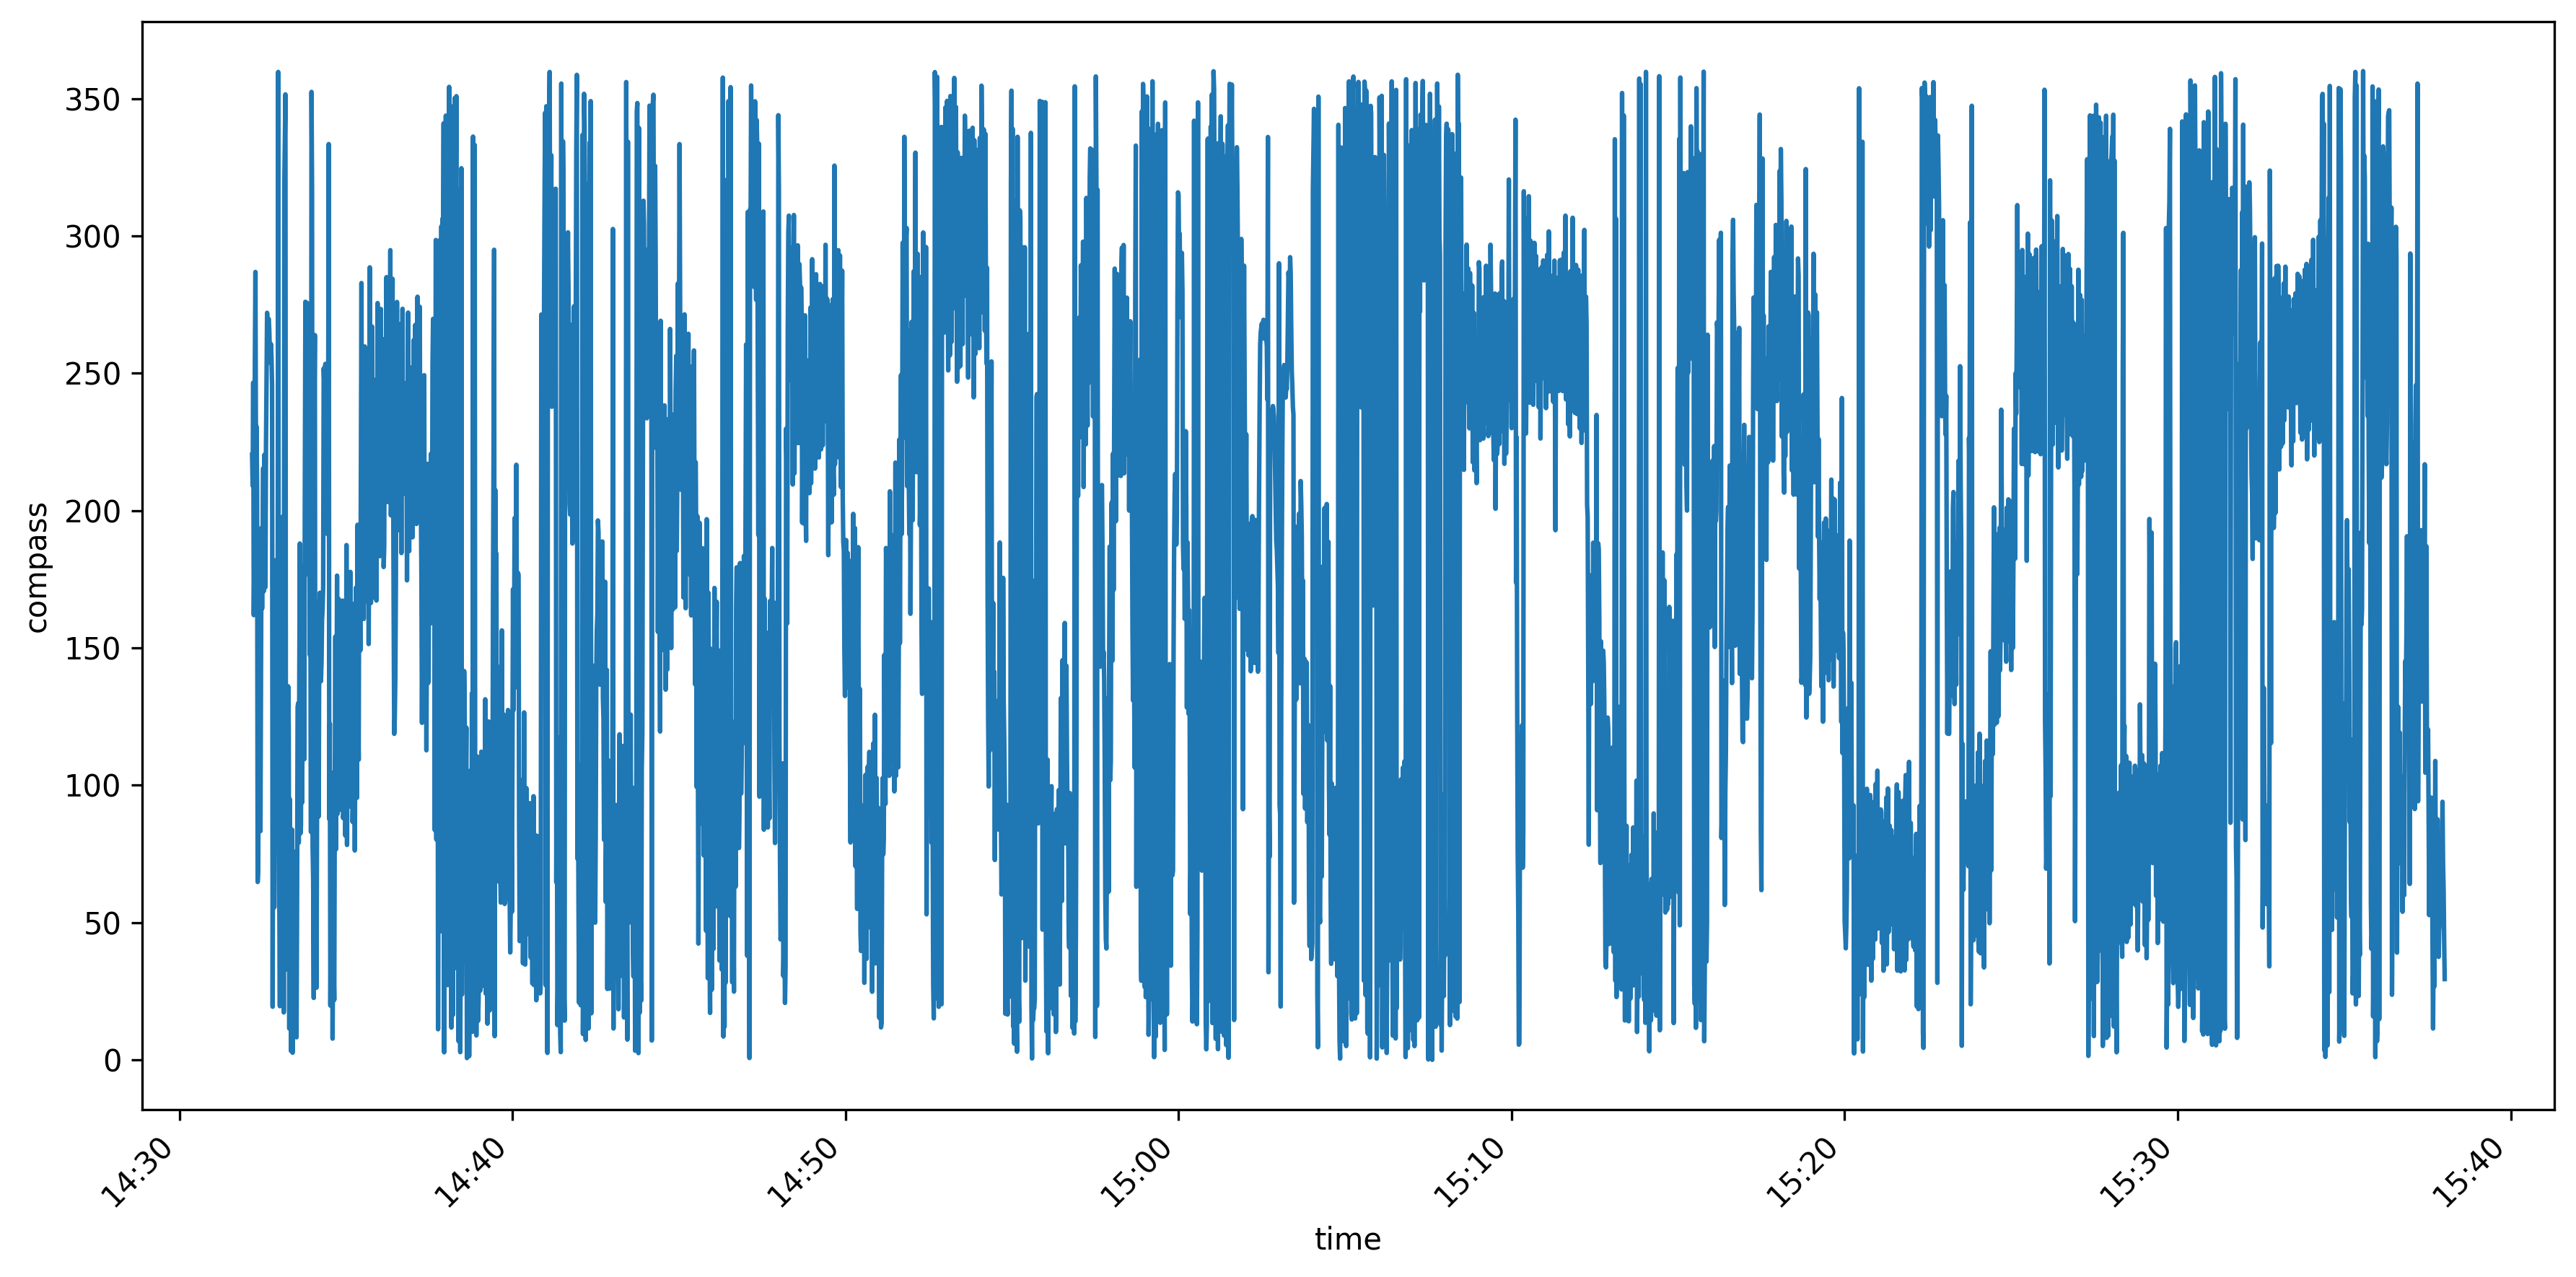

In [5]:
def plot_col(df, col):
    fig, ax = plt.subplots(figsize=(12, 6), dpi=300)
    df[col].plot()

    plt.ylabel(f'{col}')

    plt.xticks(rotation=45)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    plt.tight_layout()
    plt.show()

plot_col(df, 'compass')

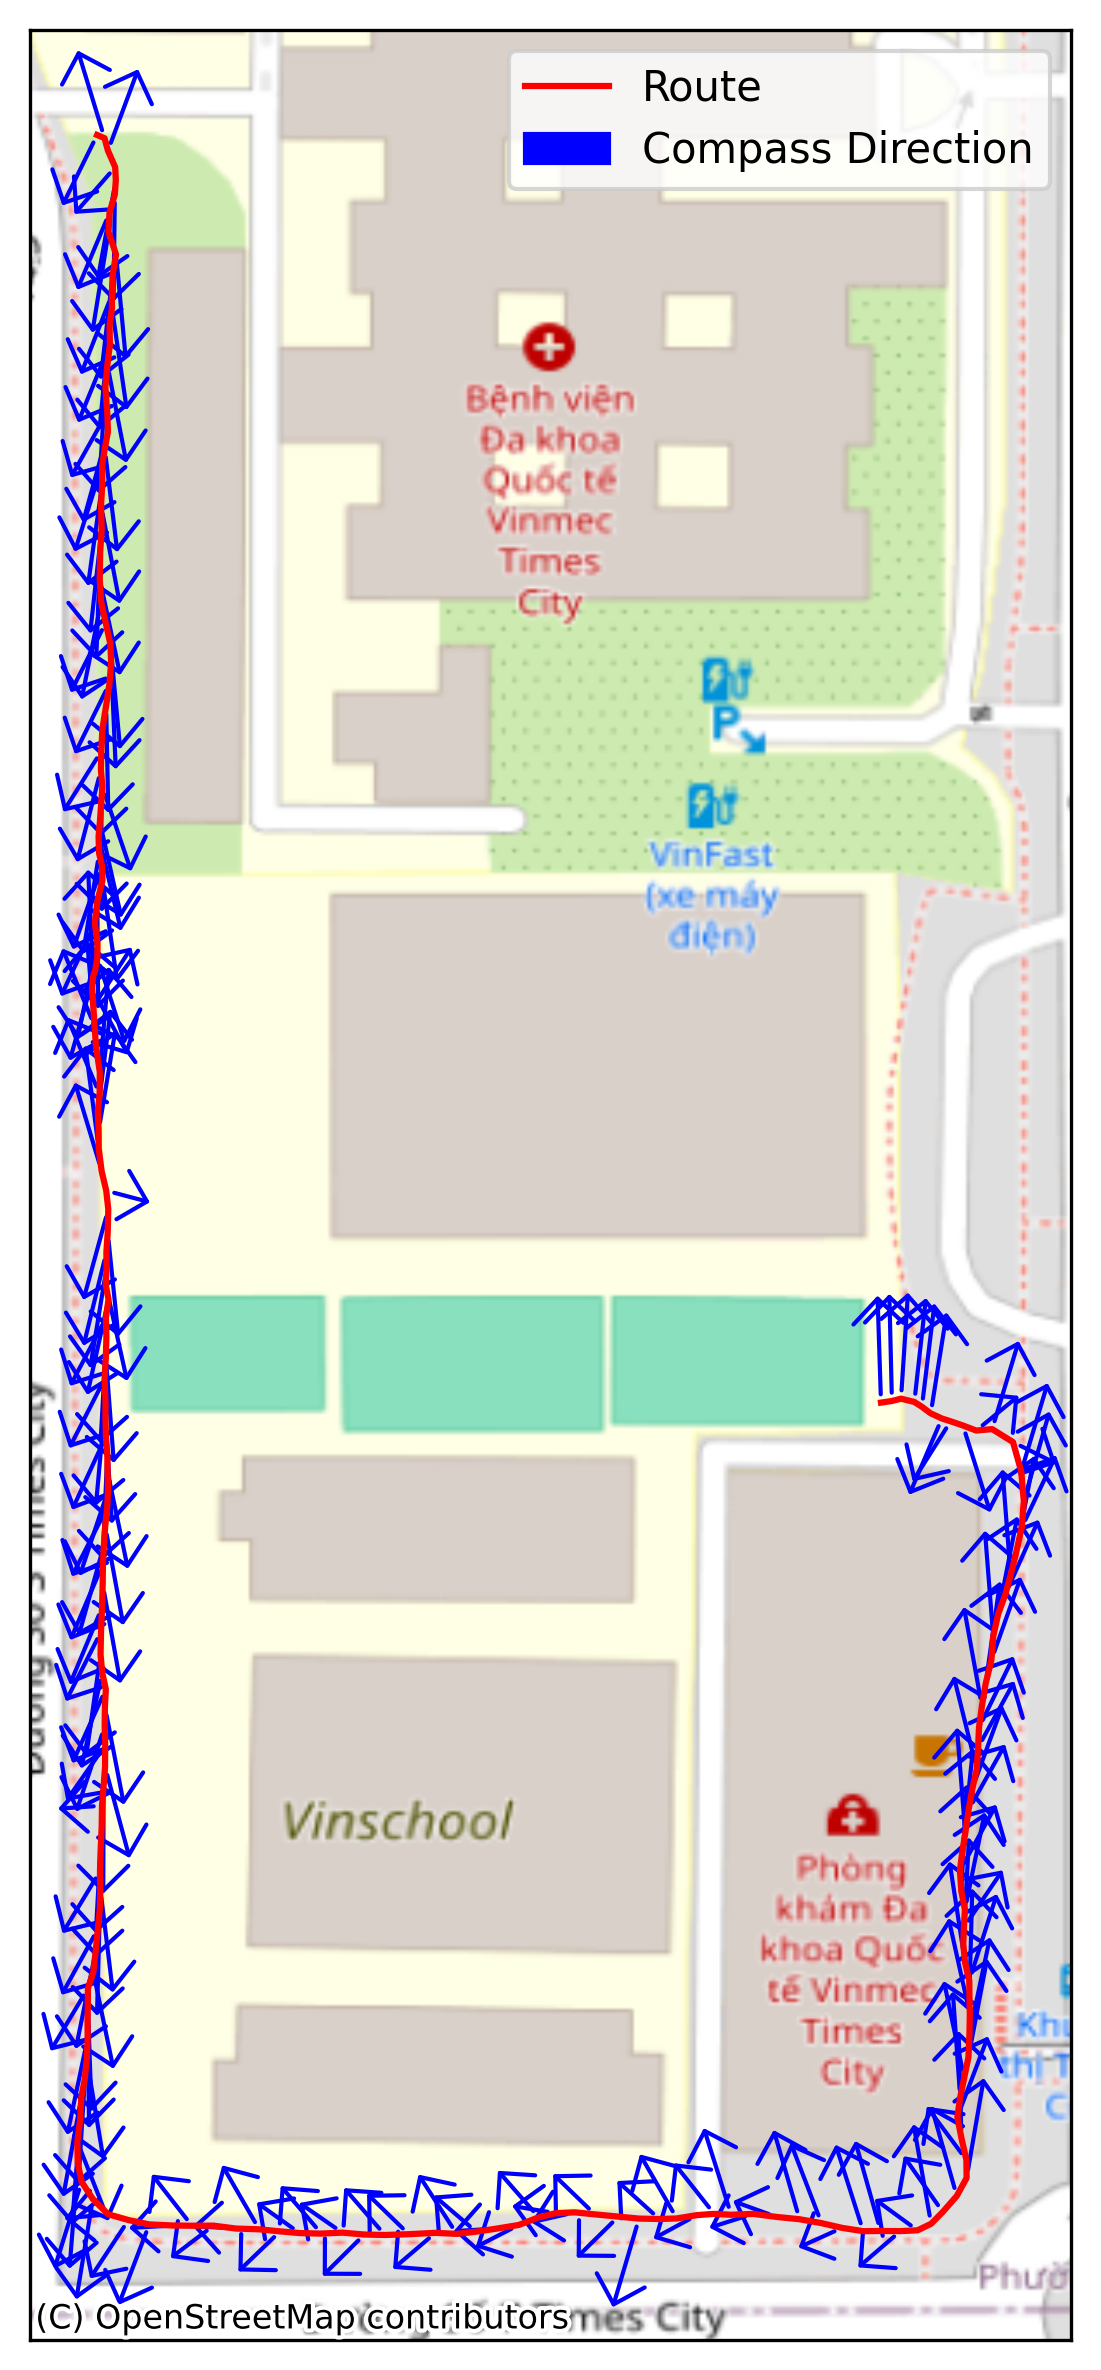

In [7]:
label_added = False  # Flag to add label only once

def plot_compass_direction(df):
  SAMPLE_SIZE = 200

  def plot_compass_arrow(ax, x, y, angle):
      global label_added

      xlim = ax.get_xlim()
      ylim = ax.get_ylim()

      x_scale = (xlim[1] - xlim[0]) * 0.05
      y_scale = (ylim[1] - ylim[0]) * 0.05

      end_x = x + np.cos(np.radians(angle)) * x_scale
      end_y = y + np.sin(np.radians(angle)) * y_scale

      arrow = FancyArrowPatch((x, y), (end_x, end_y),
                              arrowstyle='->,head_width=0.3,head_length=0.3',
                              mutation_scale=20,
                              color='b',
                              label='Compass Direction' if not label_added else None)
      ax.add_patch(arrow)
      label_added = True

  total_entries = len(df)
  if total_entries < SAMPLE_SIZE:
      df_sampled = df
  else:
      start_index = np.random.randint(0, total_entries - SAMPLE_SIZE - 1)
      df_sampled = df.iloc[start_index:start_index + SAMPLE_SIZE]

  fig, ax = plt.subplots(figsize=(10, 10), dpi=300)

  ax.plot(df_sampled['lon'], df_sampled['lat'], 'r-', label="Route")
  ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)

  for index, row in df_sampled.iterrows():
      plot_compass_arrow(ax, row['lon'], row['lat'], row['compass'])

  ax.set_aspect('equal', adjustable='box')

  ax.set_xticks([])
  ax.set_yticks([])
  ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)

  plt.legend()
  plt.show()

plot_compass_direction(df)